### Input

In [1]:
%load_ext autoreload
%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import helpfunction as helper
import awkward
import pprint

pd.set_option("display.max_columns", 500)

<IPython.core.display.Javascript object>

In [3]:
%autoreload

<IPython.core.display.Javascript object>

### Constants

In [4]:
main_tree = "NeutrinoSelectionFilter"
mass_p = 0.93827
min_p_energy = mass_p + 0.04
min_e_energy = 0.020
x_sce_magic = 1.03
pot_target = 1e20
mc_samples = ["NUE", "MC", "DIRT"]

<IPython.core.display.Javascript object>

In [5]:
max_trk_score = 0.85
min_cluster_frac = 0.5

<IPython.core.display.Javascript object>

### Load info

In [6]:
input_dir = "./input/7Oct/run3/"
output_dir = "./output/"

<IPython.core.display.Javascript object>

In [7]:
sample_info = helper.load_sample_info(input_dir, "sample_info.txt")
pot_scale = pot_target / sample_info["On"]["POT"]

<IPython.core.display.Javascript object>

### Explore Tree

In [8]:
print("Passing rate slice ID:")
for k, v in sample_info.items():
    pass_rate = sum(v["file"][main_tree].array("n_pfps") > 0) / v["numentries"]
    print(k, "\t{:.2f}%".format(pass_rate * 100))

Passing rate slice ID:
On 	23.27%
Off 	14.61%
MC 	43.93%
NUE 	79.69%
DRT 	22.50%


<IPython.core.display.Javascript object>

In [9]:
pot_nue = sample_info["NUE"]["file"]["SubRun"].array("pot").sum()
print("POT nue from sample:", pot_nue)
pot_nue_scaling = sample_info["On"]["POT"] / sample_info["NUE"]["scaling"]
print("POT nue from scaling:", pot_nue_scaling)

POT nue from sample: 9.282719e+22
POT nue from scaling: 9.239795918367347e+22


<IPython.core.display.Javascript object>

In [10]:
fields = [f.decode() for f in sample_info["NUE"]["file"][main_tree].keys()]

<IPython.core.display.Javascript object>

In [11]:
shr_fields = [f for f in fields if f.startswith("shr_") and f.endswith("_v")]
trk_fields = [f for f in fields if f.startswith("trk_") and f.endswith("_v")]
backracked_fields = [f for f in fields if f.startswith("backtracked_")]
mc_fields = [f for f in fields if f.startswith(("true_", "mc_"))]
other_fields = (
    set(fields)
    - set(shr_fields)
    - set(trk_fields)
    - set(backracked_fields)
    - set(mc_fields)
)

<IPython.core.display.Javascript object>

In [12]:
mc_fields

['true_pt',
 'true_pt_visible',
 'true_p',
 'true_p_visible',
 'true_e_visible',
 'true_nu_vtx_t',
 'true_nu_vtx_x',
 'true_nu_vtx_y',
 'true_nu_vtx_z',
 'true_nu_vtx_sce_x',
 'true_nu_vtx_sce_y',
 'true_nu_vtx_sce_z',
 'mc_pdg',
 'mc_E',
 'mc_vx',
 'mc_vy',
 'mc_vz',
 'mc_endx',
 'mc_endy',
 'mc_endz',
 'mc_px',
 'mc_py',
 'mc_pz',
 'mc_completeness',
 'mc_purity']

<IPython.core.display.Javascript object>

In [13]:
trk_fields

['trk_score_v',
 'trk_bragg_p_v',
 'trk_bragg_mu_v',
 'trk_bragg_mip_v',
 'trk_pida_v',
 'trk_pid_chipr_v',
 'trk_pid_chipi_v',
 'trk_pid_chika_v',
 'trk_pid_chimu_v',
 'trk_bragg_p_u_v',
 'trk_bragg_mu_u_v',
 'trk_bragg_mip_u_v',
 'trk_pida_u_v',
 'trk_pid_chipr_u_v',
 'trk_pid_chipi_u_v',
 'trk_pid_chika_u_v',
 'trk_pid_chimu_u_v',
 'trk_bragg_p_v_v',
 'trk_bragg_mu_v_v',
 'trk_bragg_mip_v_v',
 'trk_pida_v_v',
 'trk_pid_chipr_v_v',
 'trk_pid_chipi_v_v',
 'trk_pid_chika_v_v',
 'trk_pid_chimu_v_v',
 'trk_pfp_id_v',
 'trk_dir_x_v',
 'trk_dir_y_v',
 'trk_dir_z_v',
 'trk_start_x_v',
 'trk_start_y_v',
 'trk_start_z_v',
 'trk_end_x_v',
 'trk_end_y_v',
 'trk_end_z_v',
 'trk_distance_v',
 'trk_theta_v',
 'trk_phi_v',
 'trk_len_v',
 'trk_mcs_muon_mom_v',
 'trk_energy_proton_v',
 'trk_energy_muon_v']

<IPython.core.display.Javascript object>

In [14]:
shr_fields

['shr_dedx_u_v',
 'shr_dedx_v_v',
 'shr_dedx_y_v',
 'shr_energy_u_v',
 'shr_energy_v_v',
 'shr_energy_y_v',
 'shr_pfp_id_v',
 'shr_start_x_v',
 'shr_start_y_v',
 'shr_start_z_v',
 'shr_start_U_v',
 'shr_start_V_v',
 'shr_dist_v',
 'shr_nclus_v',
 'shr_clushitfrac_v',
 'shr_px_v',
 'shr_py_v',
 'shr_pz_v',
 'shr_openangle_v',
 'shr_theta_v',
 'shr_phi_v',
 'shr_tkfit_nhits_v',
 'shr_tkfit_start_x_v',
 'shr_tkfit_start_y_v',
 'shr_tkfit_start_z_v',
 'shr_tkfit_start_U_v',
 'shr_tkfit_start_V_v',
 'shr_tkfit_theta_v',
 'shr_tkfit_phi_v',
 'shr_tkfit_dedx_u_v',
 'shr_tkfit_dedx_v_v',
 'shr_tkfit_dedx_y_v',
 'shr_tkfit_dedx_nhits_u_v',
 'shr_tkfit_dedx_nhits_v_v',
 'shr_tkfit_dedx_nhits_y_v',
 'shr_spacepoint_start_x_v',
 'shr_spacepoint_start_y_v',
 'shr_spacepoint_start_z_v',
 'shr_spacepoint_start_U_v',
 'shr_spacepoint_start_V_v',
 'shr_hits_start_U_wire_v',
 'shr_hits_start_U_x_v',
 'shr_hits_start_V_wire_v',
 'shr_hits_start_V_x_v',
 'shr_hits_start_Y_wire_v',
 'shr_hits_start_Y_x_v']

<IPython.core.display.Javascript object>

In [15]:
backracked_fields

['backtracked_pdg',
 'backtracked_e',
 'backtracked_purity',
 'backtracked_completeness',
 'backtracked_overlay_purity',
 'backtracked_px',
 'backtracked_py',
 'backtracked_pz',
 'backtracked_start_x',
 'backtracked_start_y',
 'backtracked_start_z',
 'backtracked_start_t',
 'backtracked_start_U',
 'backtracked_start_V',
 'backtracked_start_Y',
 'backtracked_sce_start_x',
 'backtracked_sce_start_y',
 'backtracked_sce_start_z',
 'backtracked_sce_start_U',
 'backtracked_sce_start_V',
 'backtracked_sce_start_Y']

<IPython.core.display.Javascript object>

In [16]:
other_fields

{'CosmicIP',
 'bdt_cosmic',
 'bdt_ext',
 'bdt_global',
 'bdt_nuNCpi0',
 'bdt_numuCC',
 'bdt_numuCCpi0',
 'best_cosmic_flashmatch_score',
 'best_obviouscosmic_flashmatch_score',
 'category',
 'ccnc',
 'contained_fraction',
 'cosmic_flashmatch_score_v',
 'crthitpe',
 'crtveto',
 'dmc_boundary',
 'dshr_boundary',
 'dshr_x_boundary',
 'dshr_y_boundary',
 'dshr_z_boundary',
 'dtrk',
 'dtrk_boundary',
 'dtrk_x_boundary',
 'dtrk_y_boundary',
 'dtrk_z_boundary',
 'dvtx',
 'dvtx_boundary',
 'dvtx_x_boundary',
 'dvtx_y_boundary',
 'dvtx_z_boundary',
 'elec_c',
 'elec_dist',
 'elec_e',
 'elec_edep',
 'elec_etot',
 'elec_p',
 'elec_parent',
 'elec_vx',
 'elec_vy',
 'elec_vz',
 'endmuonmichel',
 'endmuonprocess',
 'evgamnhits',
 'evlepnhits',
 'evneunhits',
 'evnhits',
 'evnunhits',
 'evothnhits',
 'evpi0nhits',
 'evpi1nhits',
 'evpronhits',
 'evt',
 'extra_energy_y',
 'frac_slnoise_pl1',
 'gamma1_edep',
 'gamma1_etot',
 'gamma2_edep',
 'gamma2_etot',
 'gamma_dist',
 'gamma_edep',
 'gamma_etot',
 '

<IPython.core.display.Javascript object>

In [17]:
# search through fields:
[f for f in fields if "int" in f]

['interaction',
 'weightsReint',
 'shr_spacepoint_start_x_v',
 'shr_spacepoint_start_y_v',
 'shr_spacepoint_start_z_v',
 'shr_spacepoint_start_U_v',
 'shr_spacepoint_start_V_v']

<IPython.core.display.Javascript object>

### Load into Pandas
At some point, you might need: for df in file.pandas.iterate

In [18]:
col_pfp = ["pfnplanehits_U", "pfnplanehits_V", "pfnplanehits_Y"]
col_trk = ["trk_score_v", "trk_distance_v"]
col_shr = ["shr_dist_v", "shr_energy_y_v"]
col_backtracked = ["backtracked_pdg", "backtracked_e", "backtracked_completeness"]
col_mc = [
    "true_nu_vtx_x",
    "true_nu_vtx_y",
    "true_nu_vtx_z",
    "true_nu_vtx_sce_x",
    "true_nu_vtx_sce_y",
    "true_nu_vtx_sce_z",
    "nu_e",
    "nu_pdg",
    "theta",
    "ccnc",
    "interaction",
    "weightSpline",
    "leeweight",
]
col_event = [
    "run",
    "sub",
    "evt",
    "topological_score",
    "n_pfps",
    "n_showers",
    "n_tracks",
    "reco_nu_vtx_sce_x",
    "reco_nu_vtx_sce_y",
    "reco_nu_vtx_sce_z",
    "reco_nu_vtx_x",
    "reco_nu_vtx_y",
    "reco_nu_vtx_z",
    "crtveto",
    "slclustfrac",
]

cols_flatten = col_trk + col_shr + col_pfp
cols_reco = col_event + cols_flatten

<IPython.core.display.Javascript object>

In [19]:
%%time
# Load the sample daughter frames
for k, v in sample_info.items():
    print(k)
    cols_load = cols_reco.copy()
    if k in mc_samples:
        cols_load+= (col_mc+col_backtracked)
    v['daughters'] = v["file"][main_tree].pandas.df(cols_load, flatten=True)
    v['daughters'].index.names = ['event', 'daughter']

On
Off
MC
NUE
DRT
CPU times: user 22.4 s, sys: 300 ms, total: 22.7 s
Wall time: 20.7 s


<IPython.core.display.Javascript object>

In [20]:
# Only for signal sample:
table_cols = [
    "mc_pdg",
    "mc_E",
    "theta",
    "true_nu_vtx_x",
    "true_nu_vtx_y",
    "true_nu_vtx_z",
    "n_pfps",
    "interaction",
    "weightSpline",
    "leeweight",
]
nue_mc_arrays = sample_info["NUE"]["file"][main_tree].arrays(
    table_cols, namedecode="utf-8"
)
nue_mc_arrays["leeweight"] *= nue_mc_arrays["weightSpline"]

has_proton = (
    nue_mc_arrays["mc_E"][nue_mc_arrays["mc_pdg"] == 2212] > min_p_energy
).any()
has_electron = (
    nue_mc_arrays["mc_E"][nue_mc_arrays["mc_pdg"] == 11] > min_e_energy
).any()
has_fiducial_vtx = helper.is_fid(
    nue_mc_arrays["true_nu_vtx_x"],
    nue_mc_arrays["true_nu_vtx_y"],
    nue_mc_arrays["true_nu_vtx_z"],
)

signal_mask = has_fiducial_vtx & has_electron
sample_info["NUE"]["daughters"]["nueccinc"] = np.repeat(
    signal_mask, nue_mc_arrays["n_pfps"]
)
sample_info["NUE"]["mc"] = nue_mc_arrays

pass_rate = sum((signal_mask * nue_mc_arrays["n_pfps"]) > 0) / sum(signal_mask)
print("Nue signal passing the Slice ID \t{:.2f}%".format(pass_rate * 100))

Nue signal passing the Slice ID 	84.78%


<IPython.core.display.Javascript object>

### Add fields

In [21]:
%%time
# For all samples
for k, v in sample_info.items():
    # Add fiducial reco sce vtx
    v["daughters"]["reco_fid_vol"] = np.repeat(
        helper.is_fid(
            *v["daughters"][
                ["reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z"]
            ]
            .xs(0, level="daughter")
            .values.T
        ),
        v["daughters"]["n_pfps"].xs(0, level="daughter"),
    )
    # Add maxangle
    # Todo
    # a.distinct(b, nested=True)
    
    # Add electron candidate check
    e_cand_str = 'pfnplanehits_U & pfnplanehits_V & pfnplanehits_Y & trk_score_v<@max_trk_score'    
    electron_candidate = v["daughters"].query(e_cand_str)
    data = v["daughters"][
                [
                    "pfnplanehits_U", "pfnplanehits_V", "pfnplanehits_Y",
                    "trk_score_v",
                    "shr_energy_y_v",
                ]
            ]
    e_cand_str = "pfnplanehits_U>0 & pfnplanehits_V>0 & pfnplanehits_Y>0 & trk_score_v<@max_trk_score"
    electron_candidate = data.eval(e_cand_str)
    e_cand_maxe = data[electron_candidate]["shr_energy_y_v"].groupby("event").transform(max) == v["daughters"][electron_candidate]["shr_energy_y_v"]
    v["daughters"]["e_candidate"] = False
    v["daughters"].loc[e_cand_maxe[e_cand_maxe == True].index, "e_candidate"] = True

CPU times: user 2.16 s, sys: 56 ms, total: 2.22 s
Wall time: 1.66 s


<IPython.core.display.Javascript object>

In [22]:
%%time
# For MC samples
for k, v in sample_info.items():
    if k in mc_samples:
        # Correct the LEE weight using the splineweight
        v['daughters']["leeweight"]*=v['daughters']["weightSpline"]
        # Add distance between reco_sce and true vertex
        data = (
            v["daughters"][
                [
                    "reco_nu_vtx_sce_x",
                    "reco_nu_vtx_sce_y",
                    "reco_nu_vtx_sce_z",
                    "true_nu_vtx_x",
                    "true_nu_vtx_y",
                    "true_nu_vtx_z",
                ]
            ]
            .xs(0, level="daughter")
            .values.T
        )
        data[0]-=x_sce_magic # Correct x location for the 0.6 sign error
        
        v["daughters"]["true_vtx_distance"] = np.repeat(
            np.linalg.norm(data[0:3] - data[3:6], axis=0),
            v["daughters"]["n_pfps"].xs(0, level="daughter"),
        )
        # Cross-check vtx distance
        data = (
            v["daughters"][
                [
                    "true_nu_vtx_sce_x",
                    "true_nu_vtx_sce_y",
                    "true_nu_vtx_sce_z",
                    "reco_nu_vtx_x",
                    "reco_nu_vtx_y",
                    "reco_nu_vtx_z",
                ]
            ]
            .xs(0, level="daughter")
            .values.T
        )
        v["daughters"]["true_vtx_distance_check"] = np.repeat(
            np.linalg.norm(data[0:3] - data[3:6], axis=0),
            v["daughters"]["n_pfps"].xs(0, level="daughter"),
        )

CPU times: user 425 ms, sys: 35.9 ms, total: 461 ms
Wall time: 239 ms


<IPython.core.display.Javascript object>

In [23]:
cols_lookup = [
    "pfnplanehits_U",
    "pfnplanehits_V",
    "pfnplanehits_Y",
    "trk_score_v",
    "shr_energy_y_v",
    "shr_dist_v",
    "e_candidate",
    "backtracked_pdg",
    "reco_fid_vol",
    "crtveto",
]
sample_info["NUE"]["daughters"][cols_lookup].loc[:7]

pfnplanehits_U  pfnplanehits_V  pfnplanehits_Y  trk_score_v  \
event daughter                                                                
0     0                    116             522             775     0.068805   
2     0                     86              31              88     0.944017   
      1                     67              27              30     0.857191   
      2                     17               6              21     0.993165   
      3                      0               7               9     0.831197   
      4                      3               8               5     0.845124   
      5                      3               6               0     0.760565   
3     0                     50             115             264     0.995618   
      1                     87             215              73     0.978480   
      2                     67              68              71     0.036156   
      3                      0              40              40     0.004658   
      4                     11              41              21     0.899024   
      5                     11               6               4     0.885375   
4     0                    140              56             132     0.026412   
      1                     62              40             112     0.969382   
      2                     54              24              70     0.300715   
      3                     20              20              16     0.004113   
      4                      8               5               0     0.762992   
7     0                    257             168             191     0.007112   
      1                     86             121             146     0.967723   

                shr_energy_y_v    shr_dist_v  e_candidate  backtracked_pdg  \
event daughter                                                               
0     0           7.877512e+02  2.294480e+01         True               11   
2     0           1.684017e+02  2.635687e-01        False             2212   
      1           4.368167e+01  1.221960e+00        False              211   
      2           3.705166e+01  7.009138e-01        False               11   
      3          -3.402823e+38 -3.402823e+38        False             2212   
      4          -3.402823e+38 -3.402823e+38         True             2212   
      5          -3.402823e+38 -3.402823e+38        False             2212   
3     0           2.223447e+02  2.236893e+01        False                0   
      1           1.088965e+02  8.555756e-01        False              211   
      2           9.686684e+01  1.258941e+01         True               22   
      3           5.816462e+01  3.512400e+01        False               11   
      4           2.236086e+01  1.640399e+00        False               11   
      5          -3.402823e+38 -3.402823e+38        False              211   
4     0           1.790953e+02  2.194183e+00         True               11   
      1           1.842526e+02  8.727643e-01        False             2212   
      2           7.071710e+01  1.860114e+01        False               22   
      3           2.316853e+01  1.096010e+02        False               22   
      4          -3.402823e+38 -3.402823e+38        False             2212   
7     0           3.841982e+02  1.034956e+00         True               11   
      1           2.373854e+02  3.042643e-02        False             2212   

                reco_fid_vol  crtveto  
event daughter                         
0     0                 True        0  
2     0                False        0  
      1                False        0  
      2                False        0  
      3                False        0  
      4                False        0  
      5                False        0  
3     0                 True        0  
      1                 True        0  
      2                 True        0  
      3                 True        0  
      4                 True        0  


<IPython.core.display.Javascript object>

### Quality cuts / Pre-selection

In [24]:
query_preselect = (
    "e_candidate & reco_fid_vol & slclustfrac>@min_cluster_frac & ~crtveto"
)

<IPython.core.display.Javascript object>

In [25]:
%%time
# Passing rate pre-selection
for k, v in sample_info.items():
    v["daughters"]["preselect"] = v["daughters"].eval(
        query_preselect
    )
    pass_rate = sum(v["daughters"]["preselect"])/v['numentries']
    print(k, "\t{:.2f}%".format(pass_rate * 100))
    
# Passing rate signal, weights applied!
pass_rate = sum(sample_info["NUE"]['daughters'].eval('preselect*weightSpline*nueccinc'))/sum(sample_info["NUE"]["mc"]['weightSpline']*signal_mask)
print("Nue signal passing the preselection \t{:.2f}%".format(pass_rate * 100))
nue_pass = sum(sample_info["NUE"]['daughters'].eval('preselect*nueccinc'))*sample_info["NUE"]['scaling']*pot_scale
print("Nue Intrinsic signal passing: {0:0.3f} per {1:0.2g} POT".format(nue_pass,pot_target))
lee_pass = sum(sample_info["NUE"]['daughters'].eval('preselect*leeweight*nueccinc'))*sample_info["NUE"]['scaling']*pot_scale
print("Nue LEE signal passing: {0:0.3f} per {1:0.2g} POT".format(lee_pass,pot_target))

On 	4.49%
Off 	2.28%
MC 	11.33%
NUE 	59.73%
DRT 	1.75%
Nue signal passing the preselection 	73.06%
Nue Intrinsic signal passing: 96.315 per 1e+20 POT
Nue LEE signal passing: 10.377 per 1e+20 POT
CPU times: user 651 ms, sys: 15.9 ms, total: 667 ms
Wall time: 334 ms


/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


<IPython.core.display.Javascript object>

In [26]:
sample_info["NUE"]["daughters"]["interaction"].value_counts()

1     173507
0     125426
2      84875
10     36013
3       1327
Name: interaction, dtype: int64

<IPython.core.display.Javascript object>

### Plots

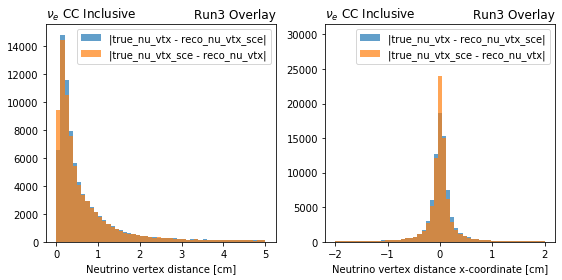

<IPython.core.display.Javascript object>

In [27]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

ax[0].hist(
    sample_info["NUE"]["daughters"]
    .query("nueccinc")["true_vtx_distance"]
    .xs(0, level="daughter"),
    bins=50,
    range=(0, 5),
    label="|true_nu_vtx - reco_nu_vtx_sce|",
    alpha=0.7,
)
ax[0].hist(
    sample_info["NUE"]["daughters"]
    .query("nueccinc")["true_vtx_distance_check"]
    .xs(0, level="daughter"),
    bins=50,
    range=(0, 5),
    label="|true_nu_vtx_sce - reco_nu_vtx|",
    alpha=0.7,
)
ax[0].set_xlabel("Neutrino vertex distance [cm]")
ax[0].set_title(r"$\nu_e$ CC Inclusive", loc="left")
ax[0].set_title("Run3 Overlay", loc="right")
ax[0].legend()

ax[1].hist(
    sample_info["NUE"]["daughters"]
    .query("nueccinc")
    .xs(0, level="daughter")
    .eval("true_nu_vtx_x+@x_sce_magic-reco_nu_vtx_sce_x"),
    bins=51,
    range=(-2, 2),
    label="|true_nu_vtx - reco_nu_vtx_sce|",
    alpha=0.7,
)
ax[1].hist(
    sample_info["NUE"]["daughters"]
    .query("nueccinc")
    .xs(0, level="daughter")
    .eval("true_nu_vtx_sce_x-reco_nu_vtx_x"),
    bins=51,
    range=(-2, 2),
    label="|true_nu_vtx_sce - reco_nu_vtx|",
    alpha=0.7,
)
ax[1].set_xlabel("Neutrino vertex distance x-coordinate [cm]")
ax[1].set_title(r"$\nu_e$ CC Inclusive", loc="left")
ax[1].set_title("Run3 Overlay", loc="right")
ax[1].set_ylim(0, ax[1].get_ylim()[1] * 1.25)
ax[1].legend()

fig.tight_layout()
fig.savefig(output_dir + "vtx_distance.pdf")

### Sandbox!